In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

import jsonlines
from pathlib import Path
from hydra import initialize, compose
import torchvision

import dr_util.file_utils as fu
import dr_gen.utils.model as mu
import dr_gen.utils.run as ru

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup Config and Generator

In [2]:
with initialize(config_path="../configs/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
    )

In [3]:
generator = ru.set_deterministic(cfg.seed)

### Find Relevant Logs

In [14]:
def get_all_logs(base_dir):
    log_dir = Path(base_dir)
    all_files = [f for f in log_dir.rglob("*.jsonl") if f.is_file()]
    all_file_data = {str(f): fu.load_file(str(f)) for f in all_files}
    return all_file_data

In [18]:
def parse_run_log(log_data):
    run_cfg = log_data[0].get("value", {})
    metrics = {k: [] for k in ['train', 'val', 'eval']}
    for l in log_data[1:]:
        data_name = l.get("data_name", None)
        if data_name in metrics:
            metrics[data_name].append(l)
    return run_cfg, metrics

In [15]:
run_logs = get_all_logs("/scratch/ddr8143/logs")

In [19]:
test_rc, test_m = parse_run_log(next(iter(run_logs.items()))[1])

In [22]:
test_m.keys()

dict_keys(['train', 'val', 'eval'])

In [25]:
test_m['train'][:5]

[{'title': 'agg_train',
  'data_name': 'train',
  'agg_stats': {'loss': 2.753891596198082,
   'acc1': 16.660000252723695,
   'acc5': 64.82000098228454}},
 {'title': 'agg_train',
  'data_name': 'train',
  'agg_stats': {'loss': 1.951957468688488,
   'acc1': 28.64000039100647,
   'acc5': 82.9525013923645}},
 {'title': 'agg_train',
  'data_name': 'train',
  'agg_stats': {'loss': 1.8111443191766738,
   'acc1': 34.202500748634336,
   'acc5': 86.40000143051148}},
 {'title': 'agg_train',
  'data_name': 'train',
  'agg_stats': {'loss': 1.6602919042110442,
   'acc1': 39.42750096321106,
   'acc5': 89.36750173568726}},
 {'title': 'agg_train',
  'data_name': 'train',
  'agg_stats': {'loss': 1.5144896268844605,
   'acc1': 44.51750102043152,
   'acc5': 91.46000146865845}}]

In [49]:
def plot_parsed_metrics(tm, lr="", wd="", initialization=""):
    # Extract acc1 values from each entry in data['train']
    acc1_values = [entry['agg_stats']['acc1'] for entry in tm['train']]
    acc1_val = [entry['agg_stats']['acc1'] for entry in tm['val']]
    acc1_eval = [entry['agg_stats']['acc1'] for entry in tm['eval']]
    
    # Create an index for each data point (0, 1, 2, ...)
    indices = list(range(len(acc1_values)))
    
    # Plotting
    plt.figure(figsize=(10, 6))
    #plt.plot(indices, acc1_values, marker='o', linestyle='-', color='b')
    plt.plot(indices, acc1_values, linestyle='-', label="train")
    plt.plot(indices, acc1_val, linestyle='-', label="val")
    plt.plot(indices, acc1_eval, linestyle='-', label="eval")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy During Training, lr{lr}, wd{wd}, {initialization}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [52]:
def plot_parsed(conf, metrics):
    plot_parsed_metrics(
        metrics,
        lr=conf['optim']['lr'],
        wd=conf['optim']['weight_decay'],
        initialization="Random Init" if conf['model']['weights'] is None else conf['model']['weights'],
    )
    

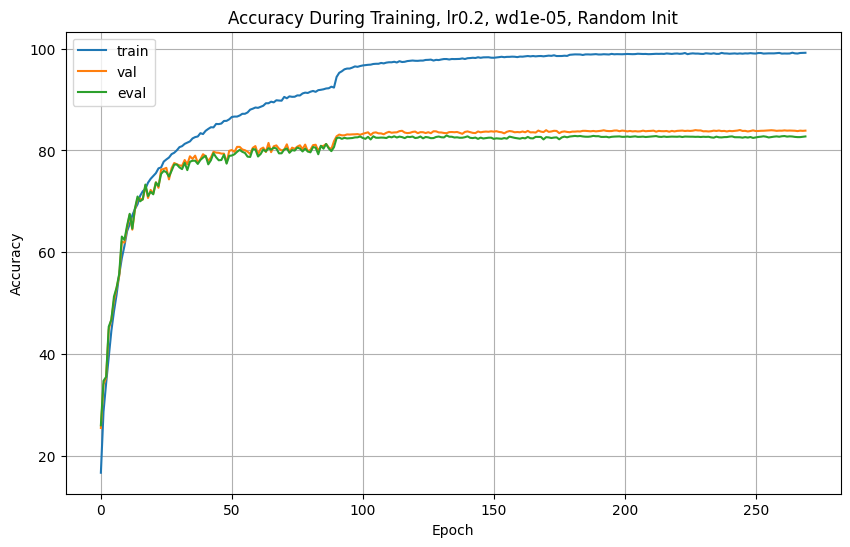

In [54]:
plot_parsed(test_rc, test_m)

In [53]:
def parse_run_logs(all_file_data):
    parsed_runs = {}
    for k, v in all_file_data.items():
        try:
            parsed_runs[k] = parse_run_log(v)
        except:
            pass
    return parsed_runs